In [1]:
# NBVAL_SKIP
# Run this cell to make the 3D plots interactive!
%matplotlib ipympl

# NanoVer Concepts: Frames


In this notebook, we'll dig into one of the main ideas in NanoVer: the **_frame_**. 

In this tutorial, you'll learn:
* What a **_frame_** is
* How NanoVer uses frames
* How to add your own custom fields to the frame

In [2]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

## What is a **frame**?

A **_frame_** is NanoVer's way of representing a molecular system or trajectory in a way that is efficient to send over a network to clients, e.g. the NanoVer iMD-VR app. 

The following schematic illustrates how this is achieved: 
* A NanoVer server receives data about the current state of the molecular simulation from the simulation engine (e.g. OpenMM)
* The server then uses this data to construct a frame (i.e. a `FrameData` object) comprising information about the simulation to be sent to the client(s)
* The `FrameData` object is serialized and transmitted using [GRPC](https://grpc.io) to client applications (see figure)

![NanoVer Frame](images/frame_server.png)

A frame is composed of two dictionaries:
* a dictionary of _arrays_: arrays are used to send lists of values of the same type, e.g. particle positions, particle elements, etc.
* a dictionary of _values_: values are used to transmit single objects, e.g. numbers, strings, etc.

<div class="alert alert-block alert-info"> <b>A Note on NanoVer Units</b> 

In NanoVer, we use the same units as our favourite MD package, [OpenMM](http://openmm.org/). 

| Quantity    | Unit              |
|-------------|-------------------|
| Distance    | nm                |
| Time        | ps                |
| mass        | atomic mass units |
| charge      | proton charge     |
| temperature | Kelvin            |
| angle       | radians           |
| energy      | kJ/mol            |

Why? Partially because we use OpenMM a lot, but also, to quote from [the OpenMM documentation](http://docs.openmm.org/latest/userguide/theory.html#units): 

> These units have the important feature that they form an internally consistent set. For example, a force always has the same units (kJ/mol/nm) whether it is calculated as the gradient of an energy or as the product of a mass and an acceleration. This is not true in some other widely used unit systems, such as those that express energy in kcal/mol.

So even though we interface with other packages that use different units, such as [ASE](https://wiki.fysik.dtu.dk/ase/ase/units.html), we always convert back to the units above when producing frames. </div>



Back to the tutorial. Let's create a frame for a water molecule. We'll do it by hand.

In [3]:
import numpy as np

In [4]:
# arrange the water molecular O H H 
water_positions = np.array([[0,0,0],[0.075545, 0.047116, 0.00000], [-0.075545, 0.047116, 0.00000 ]])
# elements are defined by their atomic numbers
water_elements = [8, 1, 1]
# Define bonds between the oxygen and the hydrogens.
water_bonds = np.array([[0, 1], [0, 2]])

Text(0.5, 0, 'Z')

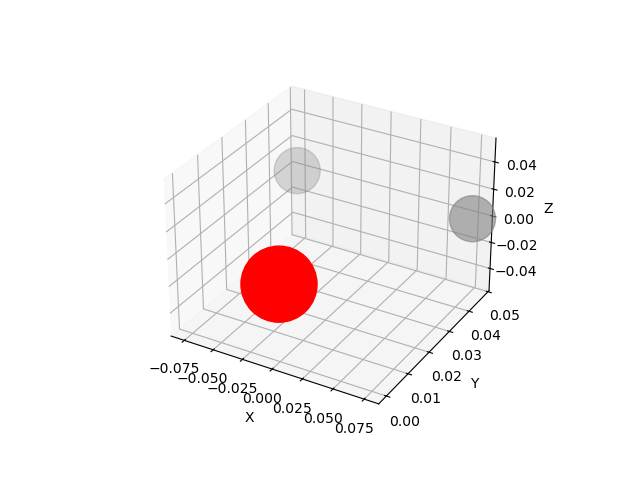

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(water_positions[:,0], water_positions[:,1], water_positions[:,2], c=['red','gray','gray'], s=[3000, 1100, 1100])
ax.grid(b=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


Now, we create an empty frame and put all of this data in by accessing the appropriate storage (arrays or values) and assigning a key.

**NOTE**: Due to the nature of GRPC, arrays must be flattened before they are added to the frame (hence the use of `flatten()` below).

In [6]:
from nanover.trajectory import FrameData

In [7]:
frame = FrameData()

In [8]:
frame.arrays['particle.positions'] = water_positions.flatten() # We have to store as a flat array.
frame.arrays['particle.elements'] = water_elements
frame.arrays['bond.pairs'] = water_bonds.flatten()

In [9]:
frame.values['particle.count'] = 3

Let's print out the frame, how this looks when communicated to clients. It's just two dictionaries, one with values, one with arrays.

In [10]:
frame.raw

values {
  key: "particle.count"
  value {
    number_value: 3
  }
}
arrays {
  key: "particle.positions"
  value {
    float_values {
      values: 0
      values: 0
      values: 0
      values: 0.075545
      values: 0.047116
      values: 0
      values: -0.075545
      values: 0.047116
      values: 0
    }
  }
}
arrays {
  key: "particle.elements"
  value {
    index_values {
      values: 8
      values: 1
      values: 1
    }
  }
}
arrays {
  key: "bond.pairs"
  value {
    index_values {
      values: 0
      values: 1
      values: 0
      values: 2
    }
  }
}

To make things easier to use, the python wrapper has shortcuts for common molecular properties:

In [11]:
frame.shortcuts

{'bond_orders',
 'bond_pairs',
 'box_vectors',
 'chain_count',
 'chain_names',
 'kinetic_energy',
 'particle_count',
 'particle_elements',
 'particle_forces',
 'particle_forces_system',
 'particle_names',
 'particle_positions',
 'particle_residues',
 'particle_velocities',
 'potential_energy',
 'residue_chains',
 'residue_count',
 'residue_ids',
 'residue_names',
 'server_timestamp',
 'simulation_counter',
 'simulation_exception',
 'simulation_time',
 'system_temperature',
 'user_energy',
 'user_forces_index',
 'user_forces_sparse',
 'user_work_done'}

We can access the `array_keys` and `value_keys` properties of the frame to see which keys have been set:

In [12]:
frame.array_keys

{'bond.pairs', 'particle.elements', 'particle.positions'}

In [13]:
frame.value_keys

{'particle.count'}

And we could have used the shortcuts to get and set the fields:

In [14]:
frame.particle_count = 3
frame.particle_positions = water_positions
frame.particle_elements = water_elements
frame.bond_pairs = water_bonds

In [15]:
frame.particle_positions

[[0.0, 0.0, 0.0],
 [0.07554499804973602, 0.0471160002052784, 0.0],
 [-0.07554499804973602, 0.0471160002052784, 0.0]]

Note that accessing the positions this way returns the particle positions as an N x 3 array: NanoVer understands the structure of common molecular properties like positions arrays, and so can reconstruct the expected format from the 1-D array passed to the frame.

We can also see what shortcuts are linked to existing data in the frame by accessing the `used_shortcuts` property:

In [16]:
frame.used_shortcuts

{'bond_pairs', 'particle_count', 'particle_elements', 'particle_positions'}

## Transmit it to VR

We've provided enough data to visualize this amazing molecule in VR. So we'll fire up a server and send this frame.

For the present purpose, we will use a `NanoverFrameApplication` server to visualise our custom frame in VR, but the methods employed to send frames in this example extend beyond simply sending a single custom frame. For instance, the `OmniRunner` class uses a derivative of this server to serve real-time iMD simulations.

In [17]:
from nanover.app import NanoverImdApplication

In [18]:
app_server = NanoverImdApplication.basic_server(port=0)

SEND FRAME!
SENT :)


In [19]:
app_server.frame_publisher.send_frame(0, frame)

If you now connect to the server from VR using the [NanoVer iMD-VR application](https://irl2.github.io/nanover-docs/tutorials/vrclient/vrclient.html), you'll see something like this:

![NanoVer H2O](images/h2o.png)

## What kind of data can I send?

You may have noticed that the particle count was transmitted as a `number_value` in the frame, and that the positions were a `float_value`. Two natural questions to ask are:
* What kind of values can you send? 
* What kind of arrays can you send? 

### Arrays

You can send arrays containing the following data types:
* decimal numbers (floats)
* positive integers (unsigned int)
* strings

The types are restricted so we can send them efficiently.

In [20]:
frame.arrays['some floats'] = [1.0, 2.5, 3.5]
frame.arrays['some numbers'] = [1,2,3]
frame.arrays['some strings'] = ['a', 'bc', 'de']

Of course, an array could just be an array of bytes (those in the business call these a `blob`). This means we can send other types of objects using arrays (e.g. images, see below)

In [21]:
with open('images/example_image.jpg', 'rb') as f:
    image_bytes = f.read()

In [22]:
frame.arrays['image'] = image_bytes

In [23]:
app_server.frame_publisher.send_frame(0, frame)

In [24]:
from nanover.websocket import NanoverImdClient
from IPython.display import Image

with NanoverImdClient.from_app_server(app_server) as client:
    client_frame = client.wait_until_first_frame()
    received_image_bytes = bytes(client_frame['image'])

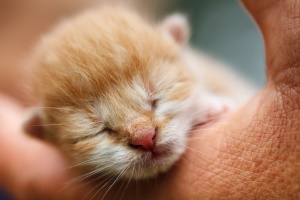

In [25]:
Image(data=received_image_bytes, width=200)

### Values

You can send values of the following types:
* boolean 
* string
* number 

It is also possible to send more complex data structures as values, such as hererogeneous lists or maps. Anything that can be represented with the Protobuf's [Value](https://developers.google.com/protocol-buffers/docs/reference/csharp/class/google/protobuf/well-known-types/value) type with **no more than 3 levels of nesting**. A selection of possible value types are given below:

In [26]:
frame.values['boolean'] = False
frame.values['string'] = 'hello'
frame.values['a number'] = 1.0
frame.values['a list'] = [2.3, 'hi!', True]
frame.values['a dictionary'] = {'hello': 'world', 'number': 42.0}

## More Molecular Data 

As well as the positions, bonds, and elements, we can set additional fields that are commonly available in topological fields formats. If these are passed, lots of exciting rendering and selection opportunites present themselves.

The following assigns the water molecule to the residue HOH, in the chain A.

In [27]:
frame.residue_ids = ['1', '1', '1']
frame.residue_names = ['HOH', 'HOH', 'HOH']
frame.residue_count = 1
frame.particle_residues = [0,0,0]
frame.chain_names = ['A']
frame.chain_count = 1
frame.residue_chains = [0]

In [28]:
app_server.frame_publisher.send_frame(0, frame)

## Updating Data in a Frame

When sending data, the iMD-VR client is intelligent enough to reuse data it has received before, so _you don't need to send the everything every time_. 

Our convention is to send the topology in the first frame, then just positions after that. The Frame server (on which the `OmniRunner` server is built) is smart enough to send the latest version of everything to a client when it first connects.

In the following, we just update the positions array to move the water molecule by 1 nanometer in each cardinal direction.

In [29]:
positions_frame = FrameData()
positions_frame.particle_positions = water_positions + 1

We can send these updated positions by passing them to `send_frame`, along with the index of the frame (here 1, as our previous frame had index 0, to indicate that this frame follows the original frame)

In [30]:
app_server.frame_publisher.send_frame(1, positions_frame)

# Tidying Up After Yourself

As ever, once we're finished we should shut down the server by calling `close()`:

In [31]:
app_server.close()

# Next Steps

In this tutorial we've learned what the frame is in NanoVer and how it works. With this in mind, here are some other tutorials to check out:

* See how frames feature in iMD-VR [simulations](../ase/ase_basic_example.ipynb) and the [trajectories](../mdanalysis/mdanalysis_trajectory.ipynb) they produced
* Learn how to set up [commands and synchronise state](commands_and_state.ipynb)
* Learn about the details of setting up [servers](servers.ipynb)